# An exploratory statistical analysis of the 2014 World Cup Final

As a fan of both data and soccer - from here on out referred to as football - I find the football fan's attitude toward statistics and data analysis perplexing, although understandable due to years and years of simple stats being the only thing that the media focuses on. Football is a complex team sport with deep interactions, therefore counting events (goals, assists, tackles, etc.) isn't enough.

This notebook shows how you can use play-by-play data to analyse a football match, showing custom measures and visualizations to better understand the sport.

Disclaimer: I'm a fan, not an expert. [Germany's National Team](http://www.telegraph.co.uk/technology/news/10959864/Germanys-World-Cup-tactics-shaped-by-data.html) and [Manchester City](http://www.wired.co.uk/magazine/archive/2014/01/features/the-winning-formula) have whole teams dedicated to data analysis, and the state of the art is quite above what is being shown here. However, rarely does that analysis is made public, so I hope this is useful (or at least entertaining). I hope to keep playing with the data and share useful insights in the future. Feel free to star the GitHub repository, or drop me at email at rjtavares@gmail.com.

###A note on the data used

This play-by-play data was gathered from a public website, and I have no guarantee that it is consistent or correct. The process used to gather will be the theme of its own post, so stay tuned. On the other hand, all calculations based on the raw data are included in this notebook, and should be questioned. I would love to get some feedback. 

### Some preprocessing

Module imports and data preparation. You can ignore this section unless you want to play with the data yourself.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from footyscripts.footyviz import draw_events, draw_pitch, type_names

#plotting settings
%matplotlib inline
pd.options.display.mpl_style = 'default'

In [2]:
df = pd.read_csv("../datasets/germany-vs-argentina-731830.csv", encoding='utf-8', index_col=0)

#standard dimensions
x_size = 105.0
y_size = 68.0
box_height = 16.5*2 + 7.32
box_width = 16.5
y_box_start = y_size/2-box_height/2
y_box_end = y_size/2+box_height/2

#scale of dataset is 100 by 100. Normalizing for a standard soccer pitch size
df['x']=df['x']/100*x_size 
df['y']=df['y']/100*y_size
df['to_x']=df['to_x']/100*x_size
df['to_y']=df['to_y']/100*y_size

#creating some measures and classifiers from the original 
df['count'] = 1
df['dx'] = df['to_x'] - df['x']
df['dy'] = df['to_y'] - df['y']
df['distance'] = np.sqrt(df['dx']**2+df['dy']**2)
df['fivemin'] = np.floor(df['min']/5)*5
df['type_name'] = df['type'].map(type_names.get)
df['to_box'] = (df['to_x'] > x_size - box_width) & (y_box_start < df['to_y']) & (df['to_y'] < y_box_end)
df['from_box'] = (df['x'] > x_size - box_width) & (y_box_start < df['y']) & (df['y'] < y_box_end)
df['on_offense'] = df['x']>x_size/2

In [3]:
#preslicing of the main DataFrame in smaller DFs that will be reused along the notebook
dfPeriod1 = df[df['period']==1]
dfP1Shots = dfPeriod1[dfPeriod1['type'].isin([13, 14, 15, 16])]
dfPeriod2 = df[df['period']==2]
dfP2Shots = dfPeriod2[dfPeriod2['type'].isin([13, 14, 15, 16])]
dfExtraTime = df[df['period']>2]
dfETShots = dfExtraTime[dfExtraTime['type'].isin([13, 14, 15, 16])]

## The first half

Let's get a quick profile of the first half. The chart below shows where in the field most events took place (positive numbers correspond to Germany's offensive half, negative numbers to its defensive half), with each team's shots pointed out.

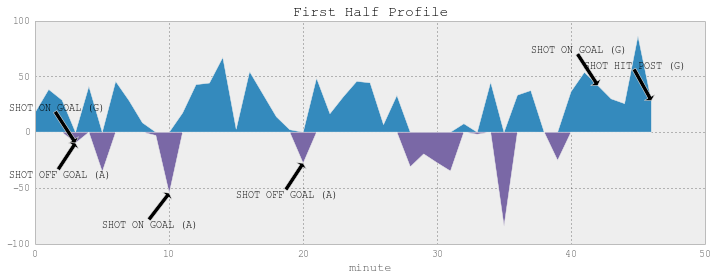

In [4]:
fig = plt.figure(figsize=(12,4))

avg_x = (dfPeriod1[dfPeriod1['team_name']=='Germany'].groupby('min').apply(np.mean)['x'] - 
         dfPeriod1[dfPeriod1['team_name']=='Argentina'].groupby('min').apply(np.mean)['x'])

plt.stackplot(list(avg_x.index.values), list([x if x>0 else 0 for x in avg_x]))
plt.stackplot(list(avg_x.index.values), list([x if x<0 else 0 for x in avg_x]))

for i, shot in dfP1Shots.iterrows():
    x = shot['min']
    y = avg_x.ix[shot['min']]
    signal = 1 if shot['team_name']=='Germany' else -1
    plt.annotate(s=(shot['type_name']+' ('+shot['team_name'][0]+")"), xy=(x, y), xytext=(x-5,y+30*signal), arrowprops=dict(facecolor='black'))

plt.gca().set_xlabel('minute')
plt.title("First Half Profile")

The first 45' of the final were incredibly interesting. Germany dominated possession and pressured high, forcing Argentina to play in its own half. That is obvious once we look at Argentina's passes during the first half:

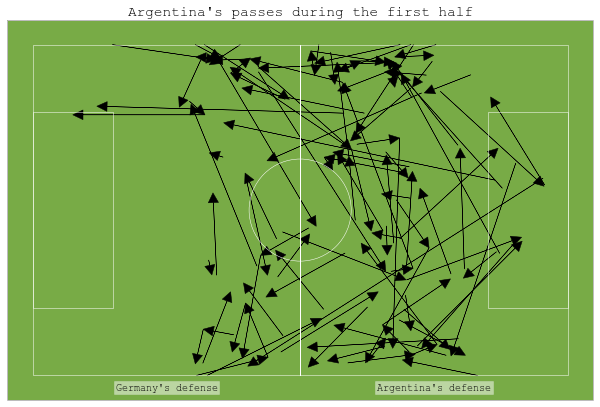

In [5]:
draw_pitch()
draw_events(dfPeriod1[(dfPeriod1['type']==1) & (dfPeriod1['outcome']==1) & (dfPeriod1['team_name']=='Argentina')], mirror_away=True)
plt.text(x_size/4, -3, "Germany's defense", color='black', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
plt.text(x_size*3/4, -3, "Argentina's defense", color='black', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
plt.title("Argentina's passes during the first half")

In [6]:
dfPeriod1.groupby('team_name').agg({'x': np.mean, 'on_offense': np.mean})

x  on_offense
team_name                       
Argentina  38.320645    0.276498
Germany    55.838736    0.610984

[2 rows x 2 columns]

In [7]:
dfPeriod1[dfPeriod1['type']==1].groupby('team_name').agg({'outcome': np.mean})

outcome
team_name          
Argentina  0.694805
Germany    0.835777

[2 rows x 1 columns]

Only 28% of Argentina's passes were made on its offensive half, versus 61% for Germany. Despite playing in the offensive half, Germany managed to get a much higher passing accuracy, a testament to its amazing midfield.

However, that superiority didn't manifest itself in chances and shots. In fact, Germany had quite a difficult time trying to get inside Argentina's penalty box.

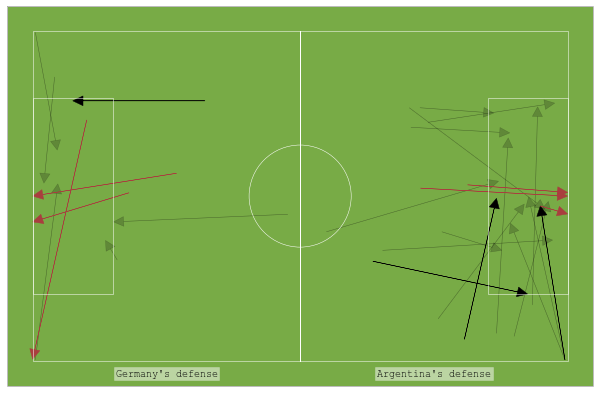

In [8]:
draw_pitch()
draw_events(df[(df['to_box']==True) & (df['type']==1) & (df['from_box']==False) & (df['period']==1) & (df['outcome']==1)], mirror_away=True)
draw_events(df[(df['to_box']==True) & (df['type']==1) & (df['from_box']==False) & (df['period']==1) & (df['outcome']==0)], mirror_away=True, alpha=0.2)
draw_events(dfP1Shots, mirror_away=True, base_color='#a93e3e')
plt.text(x_size/4, -3, "Germany's defense", color='black', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
plt.text(x_size*3/4, -3, "Argentina's defense", color='black', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')

In [9]:
dfPeriod1[(dfPeriod1['to_box']==True) & (dfPeriod1['from_box']==False) & (df['type']==1)].groupby(['team_name']).agg({'outcome': np.mean,
                                                                                                                      'count': np.sum})

count   outcome
team_name                 
Argentina      6  0.166667
Germany       16  0.187500

[2 rows x 2 columns]

Out of 16 German atempts to get in the box, only one resulted in a shot: a late corner, with Howedes hitting the post.

## The curious case of Christoph Kramer

Kramer suffered an injury on the 19th minute, but was only subsituted 12 minutes later. This included Germany's worst period in the first half, as the first half profile chart above shows.

[Reports say that he acted confused](http://www.theguardian.com/football/2014/jul/17/christoph-kramer-germany-concussion-world-cup-final-2014), and data shows that Kramer was largely "absent" in the period between the injury and the subsitutions: his only actions were one succesful reception and pass, and one loss of possesion.

In [10]:
dfKramer = df[df['player_name']=='Christoph Kramer']
pd.pivot_table(dfKramer, values='count', rows='type_name', cols='min', aggfunc=sum, fill_value=0)

min                        0   1   4   6   7   8   11  19  24  25  31
type_name                                                            
CLEAR BALL (OUT OF PITCH)   0   0   0   0   0   0   0   1   0   0   0
LINEUP                      1   0   0   0   0   0   0   0   0   0   0
LOST CONTROL OF BALL        0   0   0   0   0   0   0   0   0   1   0
PASS                        0   1   2   1   2   1   2   0   1   0   0
RECEPTION                   0   1   2   1   2   1   1   0   1   0   0
RUN WITH BALL               0   1   0   0   0   1   1   0   0   0   0
SUBSTITUTION (OFF)          0   0   0   0   0   0   0   0   0   0   1
TACKLE                      0   0   0   0   0   0   1   0   0   0   0

[8 rows x 11 columns]

In [11]:
dfKramer['action']=dfKramer['outcome'].map(str) + '-' + dfKramer['type_name']
dfKramer['action'].unique()

array(['1-LINEUP', '1-RUN WITH BALL', '1-RECEPTION', '1-PASS', '0-PASS',
       '0-TACKLE', '1-CLEAR BALL (OUT OF PITCH)', '0-LOST CONTROL OF BALL',
       '1-SUBSTITUTION (OFF)'], dtype=object)

In [12]:
score = {'1-LINEUP': 0, '1-RUN WITH BALL': 0.5, '1-RECEPTION': 0, '1-PASS': 1, '0-PASS': -1,
       '0-TACKLE (NO CONTROL)': 0, '1-CLEAR BALL (OUT OF PITCH)': 0.5,
       '0-LOST CONTROL OF BALL': -1, '1-SUBSTITUTION (OFF)': 0}

dfKramer['score'] = dfKramer['action'].map(score.get)

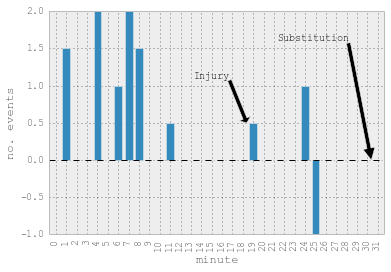

In [13]:
dfKramer.groupby('min')['score'].sum().reindex(range(32), fill_value=0).plot(kind='bar')
plt.annotate('Injury', (19,0.5), (14,1.1), arrowprops=dict(facecolor='black'))
plt.annotate('Substitution', (31,0), (22,1.6), arrowprops=dict(facecolor='black'))
plt.gca().set_xlabel('minute')
plt.gca().set_ylabel('no. events')

## The second half

The second half was much more balanced. We reproduce the same charts as the first half, which confirm this perception.

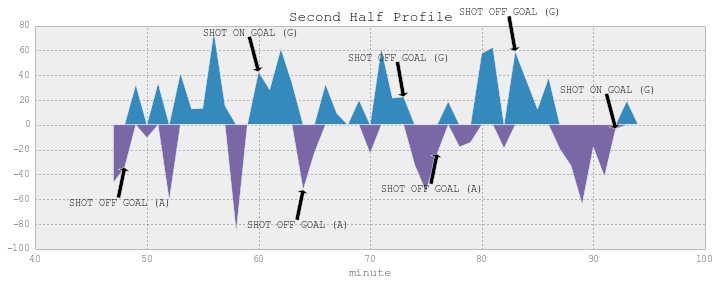

In [14]:
fig = plt.figure(figsize=(12,4))

avg_x = (dfPeriod2[dfPeriod2['team_name']=='Germany'].groupby('min').apply(np.mean)['x'] - 
         dfPeriod2[dfPeriod2['team_name']=='Argentina'].groupby('min').apply(np.mean)['x'])

plt.stackplot(list(avg_x.index.values), list([x if x>0 else 0 for x in avg_x]))
plt.stackplot(list(avg_x.index.values), list([x if x<0 else 0 for x in avg_x]))

for i, shot in dfP2Shots.iterrows():
    x = shot['min']
    y = avg_x.ix[shot['min']]
    signal = 1 if shot['team_name']=='Germany' else -1
    plt.annotate(s=(shot['type_name']+' ('+shot['team_name'][0]+")"), xy=(x, y), xytext=(x-5,y+30*signal), arrowprops=dict(facecolor='black'))

plt.gca().set_xlabel('minute')
plt.title("Second Half Profile")

In [15]:
dfPeriod2.groupby('team_name').agg({'x': np.mean, 'on_offense': np.mean})

x  on_offense
team_name                       
Argentina  48.916711    0.415625
Germany    54.551298    0.598582

[2 rows x 2 columns]

In [16]:
dfPeriod2[dfPeriod2['type']==1].groupby('team_name').agg({'outcome': np.mean})

outcome
team_name          
Argentina  0.817427
Germany    0.839695

[2 rows x 1 columns]

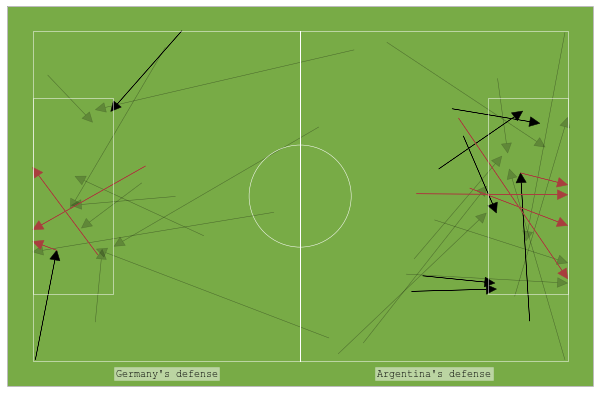

In [17]:
draw_pitch()
draw_events(df[(df['to_box']==True) & (df['type']==1) & (df['from_box']==False) & (df['period']==2) & (df['outcome']==1)], mirror_away=True)
draw_events(df[(df['to_box']==True) & (df['type']==1) & (df['from_box']==False) & (df['period']==2) & (df['outcome']==0)], mirror_away=True, alpha=0.2)
draw_events(dfP2Shots, mirror_away=True, base_color='#a93e3e')
plt.text(x_size/4, -3, "Germany's defense", color='black', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
plt.text(x_size*3/4, -3, "Argentina's defense", color='black', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')

Even though Germany had much more success getting inside the box on the second half, only only pass resulted in a German shot from inside the box.

In [18]:
dfPeriod2[(dfPeriod2['to_box']==True) & (dfPeriod2['from_box']==False) & (df['type']==1)].groupby(['team_name']).agg({'outcome': np.mean,
                                                                                                                      'count': np.sum})

count   outcome
team_name                 
Argentina     12  0.166667
Germany       16  0.375000

[2 rows x 2 columns]

## The extra time

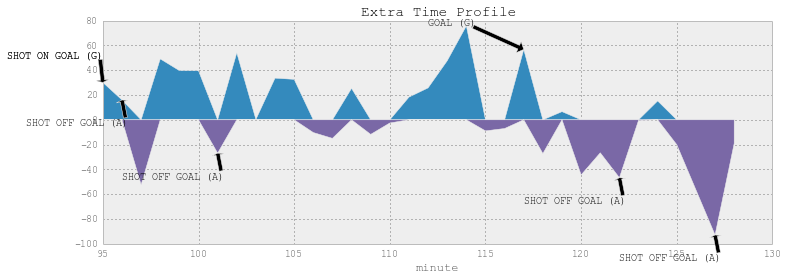

In [19]:
fig = plt.figure(figsize=(12,4))

avg_x = (dfExtraTime[dfExtraTime['team_name']=='Germany'].groupby('min').apply(np.mean)['x'] - 
         dfExtraTime[dfExtraTime['team_name']=='Argentina'].groupby('min').apply(np.mean)['x'].reindex(dfExtraTime['min'].unique(), fill_value=0))

plt.stackplot(list(avg_x.index.values), list([x if x>0 else 0 for x in avg_x]))
plt.stackplot(list(avg_x.index.values), list([x if x<0 else 0 for x in avg_x]))

for i, shot in dfETShots.iterrows():
    x = shot['min']
    y = avg_x.ix[shot['min']]
    signal = 1 if shot['team_name']=='Germany' else -1
    plt.annotate(s=(shot['type_name']+' ('+shot['team_name'][0]+")"), xy=(x, y), xytext=(x-5,y+20*signal), arrowprops=dict(facecolor='black'))

plt.gca().set_xlabel('minute')
plt.title("Extra Time Profile")

In [20]:
df.groupby(['team_name', 'period']).agg({'count': np.sum, 'x': np.mean, 'on_offense': np.mean})

count          x  on_offense
team_name period                              
Argentina 1         434  38.320645    0.276498
          2         640  48.916711    0.415625
          3         105  46.100000    0.400000
          4         152  46.255263    0.361842
Germany   1         874  55.838736    0.610984
          2         705  54.551298    0.598582
          3         376  60.176729    0.659574
          4         209  45.543876    0.392344

[8 rows x 3 columns]

We can see that Germany's 4th period was quite different from the rest of the match. Germany played a lot less high on the field, and decreased the number of passes significantly: showing that it tried to control the game, slow it down, dropping the defensive line. This is even more evident if we look at the time interval after the goal:

In [21]:
goal_ix = df[df['type']==16].index[0]
df.ix[goal_ix+1:].groupby(['team_name', 'period']).agg({'count': np.sum, 'x': np.mean, 'on_offense': np.mean})

count          x  on_offense
team_name period                              
Argentina 4          90  52.444000    0.433333
Germany   4          64  35.009297    0.343750

[2 rows x 3 columns]

C:\Anaconda\lib\site-packages\pandas\core\frame.py:1663: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


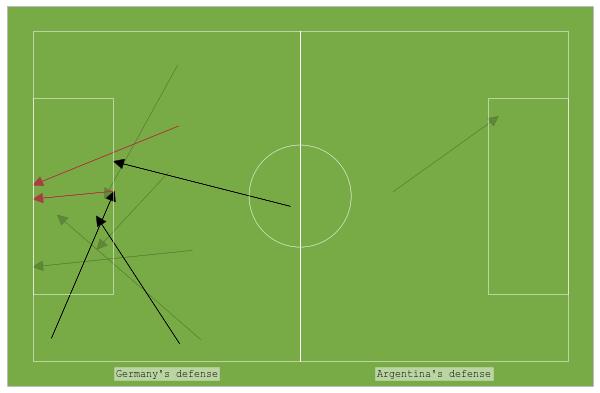

In [22]:
draw_pitch()
draw_events(df.ix[goal_ix+1:][(df['to_box']==True) & (df['type']==1) & (df['from_box']==False) & (df['outcome']==1)], mirror_away=True)
draw_events(df.ix[goal_ix+1:][(df['to_box']==True) & (df['type']==1) & (df['from_box']==False) & (df['outcome']==0)], mirror_away=True, alpha=0.2)
draw_events(df.ix[goal_ix+1:][df['type'].isin([13,14,15,16])], mirror_away=True, base_color='#a93e3e')
plt.text(x_size/4, -3, "Germany's defense", color='black', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
plt.text(x_size*3/4, -3, "Argentina's defense", color='black', bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')

In [23]:
df.ix[goal_ix+1:][df.ix[goal_ix+1:]['type'].isin([13,14,15,16])][['min', 'player_name', 'team_name', 'type_name']]

min   player_name  team_name      type_name
3420  122  Lionel Messi  Argentina  SHOT OFF GOAL
3481  127  Lionel Messi  Argentina  SHOT OFF GOAL

[2 rows x 4 columns]

Germany completely gave up trying to score another goal, with only one attempt at a pass to the box. However, its defensive strategy was successful, with Argentina barely entering Germany's penalty box. Its only 2 shots came from outside the box, both by Messi, who at this point was probably feeling somewhat desperate.

## The goal

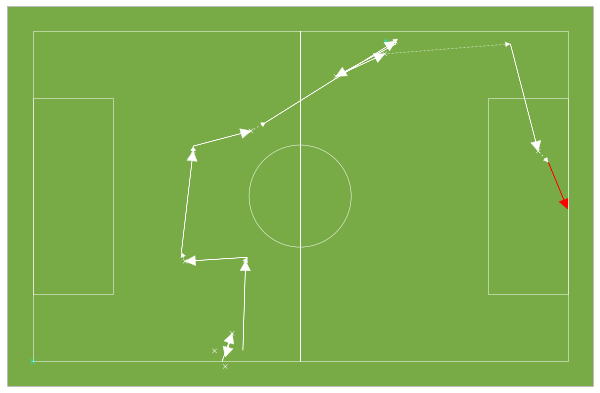

In [24]:
goal = df[df['type']==16].index[0]
dfGoal = df.ix[goal-30:goal]

draw_pitch()
draw_events(dfGoal[dfGoal.team_name=='Germany'], base_color='white')
draw_events(dfGoal[dfGoal.team_name=='Argentina'], base_color='cyan')

In [25]:
#Germany's players involved in the play
dfGoal['progression']=dfGoal['to_x']-dfGoal['x']
dfGoal[dfGoal['type'].isin([1, 101, 16])][['player_name', 'type_name', 'progression']]

player_name      type_name  progression
3311            Philipp Lahm           PASS        1.995
3313  Bastian Schweinsteiger           PASS       -1.365
3317            Philipp Lahm           PASS        0.525
3319  Bastian Schweinsteiger  RUN WITH BALL        0.315
3320  Bastian Schweinsteiger           PASS      -12.180
3321          Jerome Boateng  RUN WITH BALL       -0.735
3323          Jerome Boateng           PASS        2.310
3325            Mats Hummels  RUN WITH BALL        0.000
3326            Mats Hummels           PASS       11.340
3327              Toni Kroos  RUN WITH BALL        2.940
3329              Toni Kroos           PASS       25.410
3331          André Schürrle  RUN WITH BALL        0.105
3332          André Schürrle           PASS      -11.760
3334              Toni Kroos           PASS        9.555
3336          André Schürrle  RUN WITH BALL       24.675
3337          André Schürrle           PASS        5.460
3339             Mario Götze  RUN WITH BALL        1.995
3340             Mario Götze           GOAL        3.780

[18 rows x 3 columns]

## Some basic stats

In [26]:
#passing accuracy
df.groupby(['player_name', 'team_name']).agg({'count': np.sum, 'outcome': np.mean}).sort('count', ascending=False)

count   outcome
player_name            team_name                 
Philipp Lahm           Germany      296  0.925676
Toni Kroos             Germany      287  0.885017
Bastian Schweinsteiger Germany      271  0.926199
Jerome Boateng         Germany      211  0.909953
Mesut Özil             Germany      196  0.867347
Javier Mascherano      Argentina    173  0.878613
André Schürrle         Germany      172  0.825581
Benedikt Höwedes       Germany      167  0.856287
Mats Hummels           Germany      165  0.909091
Thomas Müller          Germany      155  0.812903
Lucas Biglia           Argentina    136  0.860294
Ezequiel Garay         Argentina    131  0.893130
Martín Demichelis      Argentina    126  0.888889
Pablo Zabaleta         Argentina    122  0.786885
Lionel Messi           Argentina    122  0.770492
Marcos Rojo            Argentina    119  0.798319
Manuel Neuer           Germany       98  0.897959
Enzo Pérez             Argentina     89  0.876404
Sergio Agüero          Argentina     69  0.753623
Sergio Romero          Argentina     69  0.681159
Miroslav Klose         Germany       58  0.724138
Fernando Gago          Argentina     57  0.859649
Mario Götze            Germany       57  0.894737
Gonzalo Higuaín        Argentina     53  0.792453
Ezequiel Lavezzi       Argentina     34  0.764706
Rodrigo Palacio        Argentina     31  0.612903
Christoph Kramer       Germany       27  0.888889
Per Mertesacker        Germany        4  1.000000

[28 rows x 2 columns]

In [27]:
#shots
pd.pivot_table(df[df['type'].isin([13,14,15,16])],
               values='count',
               aggfunc=sum,
               rows=['player_name', 'team_name'], 
               cols='type_name',
               fill_value=0,
               margins=True).sort('All', ascending=False)

type_name                   GOAL  SHOT HIT POST  SHOT OFF GOAL  SHOT ON GOAL  \
player_name      team_name                                                     
All                            1              1             11             7   
Lionel Messi     Argentina     0              0              4             0   
Toni Kroos       Germany       0              0              1             2   
Sergio Agüero    Argentina     0              0              2             0   
Mario Götze      Germany       1              0              0             1   
Gonzalo Higuaín  Argentina     0              0              2             0   
André Schürrle   Germany       0              0              1             1   
Rodrigo Palacio  Argentina     0              0              1             0   
Miroslav Klose   Germany       0              0              0             1   
Mesut Özil       Germany       0              0              0             1   
Lucas Biglia     Argentina     0              0              0             1   
Benedikt Höwedes Germany       0              1              0             0   

type_name                   All  
player_name      team_name       
All                          20  
Lionel Messi     Argentina    4  
Toni Kroos       Germany      3  
Sergio Agüero    Argentina    2  
Mario Götze      Germany      2  
Gonzalo Higuaín  Argentina    2  
André Schürrle   Germany      2  
Rodrigo Palacio  Argentina    1  
Miroslav Klose   Germany      1  
Mesut Özil       Germany      1  
Lucas Biglia     Argentina    1  
Benedikt Höwedes Germany      1  

[12 rows x 5 columns]

In [28]:
#defensive play
pd.pivot_table(df[df['type'].isin([7, 8, 49])],
               values='count',
               aggfunc=np.sum,
               rows=['player_name', 'team_name'], 
               cols='type_name',
               fill_value=0,
               margins=True).sort('All', ascending=False)

type_name                         INTERCEPTION  TACKLE  WON CONTROL OF BALL  \
player_name            team_name                                              
All                                         35      51                  109   
Martín Demichelis      Argentina             5       2                    9   
Toni Kroos             Germany               2       3                   11   
Bastian Schweinsteiger Germany               0       4                   11   
Mats Hummels           Germany               3       6                    6   
Jerome Boateng         Germany               3       6                    5   
Pablo Zabaleta         Argentina             1       8                    4   
Enzo Pérez             Argentina             2       1                    7   
Javier Mascherano      Argentina             3       2                    5   
Philipp Lahm           Germany               2       0                    7   
Marcos Rojo            Argentina             3       3                    3   
Thomas Müller          Germany               2       1                    5   
Miroslav Klose         Germany               2       3                    3   
Ezequiel Garay         Argentina             3       2                    3   
Benedikt Höwedes       Germany               1       2                    4   
André Schürrle         Germany               0       3                    2   
Lucas Biglia           Argentina             2       0                    3   
Gonzalo Higuaín        Argentina             0       0                    4   
Mesut Özil             Germany               0       1                    3   
Lionel Messi           Argentina             0       1                    2   
Ezequiel Lavezzi       Argentina             0       1                    2   
Sergio Agüero          Argentina             1       1                    1   
Sergio Romero          Argentina             0       0                    3   
Fernando Gago          Argentina             0       0                    2   
Rodrigo Palacio        Argentina             0       0                    2   
Mario Götze            Germany               0       0                    1   
Christoph Kramer       Germany               0       1                    0   
Manuel Neuer           Germany               0       0                    1   

type_name                         All  
player_name            team_name       
All                               195  
Martín Demichelis      Argentina   16  
Toni Kroos             Germany     16  
Bastian Schweinsteiger Germany     15  
Mats Hummels           Germany     15  
Jerome Boateng         Germany     14  
Pablo Zabaleta         Argentina   13  
Enzo Pérez             Argentina   10  
Javier Mascherano      Argentina   10  
Philipp Lahm           Germany      9  
Marcos Rojo            Argentina    9  
Thomas Müller          Germany      8  
Miroslav Klose         Germany      8  
Ezequiel Garay         Argentina    8  
Benedikt Höwedes       Germany      7  
André Schürrle         Germany      5  
Lucas Biglia           Argentina    5  
Gonzalo Higuaín        Argentina    4  
Mesut Özil             Germany      4  
Lionel Messi           Argentina    3  
Ezequiel Lavezzi       Argentina    3  
Sergio Agüero          Argentina    3  
Sergio Romero          Argentina    3  
Fernando Gago          Argentina    2  
Rodrigo Palacio        Argentina    2  
Mario Götze            Germany      1  
Christoph Kramer       Germany      1  
Manuel Neuer           Germany      1  

[28 rows x 4 columns]

In short: Kroos and Schweinsteiger were imense in Germany's midield. Kroos had the most defensive actions, the second most shots (behind Messi only due to his desperate late atempts), and the second most passes. He was also responsible for most of the progression in Germany's goal-leading play. He was objectively the man of the match. Why FIFA decided to give that award to Goetze is beyond me (and most football fans).

## What's missing?

Football is a game of space. That's why [parking the bus can actually allow to win a match](http://www.mirror.co.uk/sport/football/news/liverpool-vs-chelsea-jose-mourinho-3469108). The dataset used only includes positions for players active offensive and defensive actions. Defensive positioning is therefore completely ignored, and even attacking play lacks important information: a player's run without the ball can be much more important than a pass to score a goal.

After all, without the position of the defenders, what's so special about an assist like this one:

In [1]:
from IPython.display import Image
Image(url='http://i.minus.com/ibpQVB7fHa5NDj.gif')